# Custom models and its evaluation

### Tasks

1. Implementation loss+ and objective function+ 
2. Create preprocessing pipeline
3. Hyper-parameters tuning
4. Own implementation of Cross-Validation procedure.+
5. Implement L1 and L2 (or Lp) regularization for polynomial regression+
6. Find optimal regularization method and coefficient +

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20,8]

## Get data

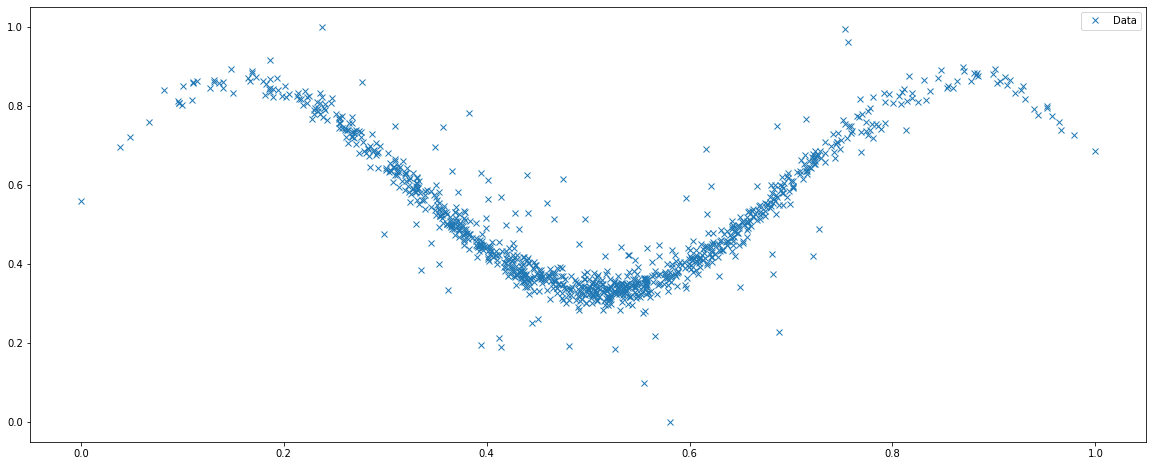

In [ ]:
n_samples = 1000
n_outliers = 100
X, y = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=35,
                                      coef=False, random_state=1110)
X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 250 * np.random.normal(size=n_outliers)
y = y+500*X.T[0]*np.sin(X.T[0])
#X = (X - X.min())/(X.max()-X.min())
#y = (y - y.min())/(y.max()-y.min())
# y_pred = np.asanyarray(y_pred)
minmaxscaler = preprocessing.MinMaxScaler()
X = minmaxscaler.fit_transform(X)
y = (y - y.min())/(y.max()-y.min())
#y = np.reshape(y,(-1, 1))
#y = minmaxscaler.fit_transform(y)
plt.plot(X, y, 'x', label = 'Data')
plt.legend()

# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

### Log-Cosh Loss

$$ \text{L} (y^t, y^p) = \sum_{i=1}^n \log(\cosh(y_i^p - y_i^p)) $$

In [ ]:
def logcosh(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    logcosh = np.sum(np.log(np.cosh(y_true-y_pred)))
    return logcosh

def predict(X, theta): #h_theta(x)
    return np.dot(X, theta)

def objective_function(theta, X,y, loss_function=logcosh, alpha = 0):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  
  return loss_function(y_true, y_pred)

In [ ]:
print('Error of random prediction: %.2f'%logcosh(y, np.random.random(len(y))) )
print('Error of random model: %.2f'%logcosh(y, predict(X_I, theta = np.random.random(len(X_I[0])))))

Error of random prediction: 57.87
Error of random model: 34.05


## Train model

In [ ]:
from scipy import optimize

In [ ]:
theta_init = np.array([1]*X_I.shape[1]) # initial value of theta

result = optimize.minimize(
                           objective_function,  
                           args=(X_I, y, logcosh),
                           x0 = theta_init,  
                           method='Powell',
                           options={}  
                           )
print('Optimization result:', ['FAIL','Success'][result.success])
print('Comment:', result.message)
print('Objective function value:', result.fun)
print('Found theta:', result.x)

Optimization result: Success
Comment: Optimization terminated successfully.
Objective function value: 15.189621358392356
Found theta: [ 0.53698308 -0.05302512]


In [ ]:
def custom_regression(X, y, 
                      objective_function=objective_function, 
                      loss_function=logcosh, 
                      init = 1, 
                      verbose = True, 
                      iters = 10):
  
  theta_init = np.ones_like(X[0]) * init
  result = optimize.minimize(objective_function,
                             args=(X, y, loss_function), 
                             x0 = theta_init, 
                             method='Powell', 
                             options={'maxiter': iters})
  theta = result['x']
  return theta

## Add polynomial features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

n = 10 # power of polynom
polynomial_features = PolynomialFeatures(degree=n,include_bias=True) # create instance of preprocessor
X_a = polynomial_features.fit_transform(X) # apply transformation
X_a.shape

(1000, 11)

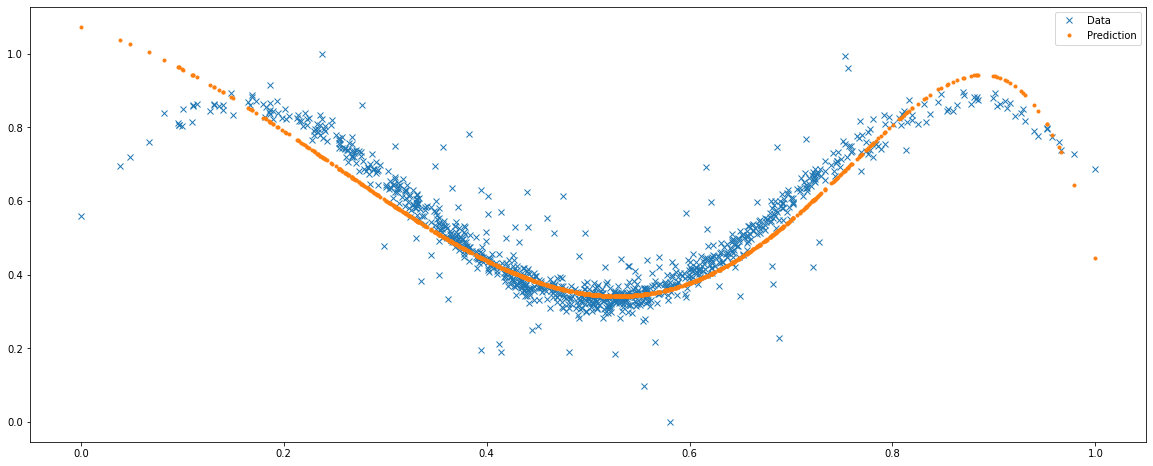

In [ ]:
theta = custom_regression(X_a, y, objective_function=objective_function, loss_function=logcosh)
y_pred = predict(X_a, theta)
plt.plot(X, y, 'x', label = 'Data')
ax = plt.gca()
ax.autoscale(enable = True)
plt.plot(X, y_pred, '.', label = 'Prediction')
plt.legend()

In [ ]:
from sklearn.model_selection import train_test_split
degrees = [1,2,5,10,25,50]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

CPU times: user 2.13 s, sys: 1.39 s, total: 3.52 s
Wall time: 1.9 s


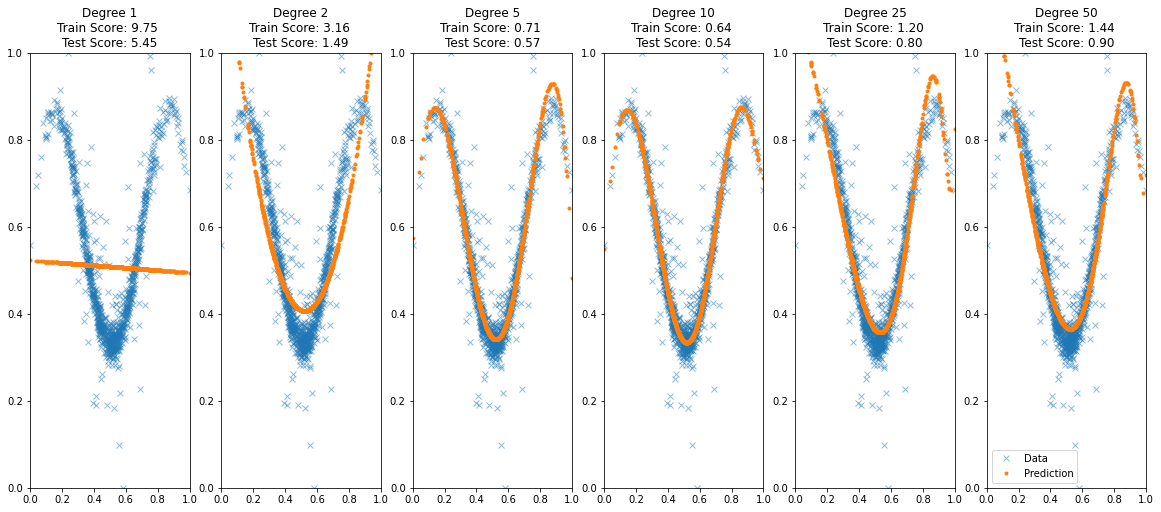

In [ ]:
%%time
for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
  
  # make transformation of all data subsets
  X_all = polynomial_features.fit_transform(X)
  X_a_train = polynomial_features.fit_transform(X_train)
  X_a_test = polynomial_features.fit_transform(X_test)
  
  # train model
  theta = custom_regression(X_a_train, y_train, objective_function=objective_function, loss_function=logcosh, iters = 20)
  
  # test model
  y_pred_test = predict(X_a_test, theta)
  y_pred_train = predict(X_a_train, theta)
  test_score = objective_function(theta=theta, X=X_a_test, y=y_test)
  train_score = objective_function(theta=theta, X=X_a_train, y=y_train)
  
  #visualize results
  y_pred = predict(X_all, theta)
  
  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, 'x', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(X, y_pred, '.', label = 'Prediction')
  plt.title("Degree %i\nTrain Score: %.2f \nTest Score: %.2f"%(degrees[i], train_score, test_score))
plt.legend()

### Prepare pipeline

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin 

In [ ]:
class CustomRegression(BaseEstimator, RegressorMixin):                           
  def __init__(self, loss_function=logcosh, objective_function=objective_function): # all arguments should have default values
    self.theta = None 
    self.loss_function = loss_function 
    self.objective_function = objective_function
    
  def predict(self, X):
    return predict(X, self.theta)
  
  def score(self, X, y):
    return self.objective_function(theta=self.theta, X=X,y=y,loss_function=self.loss_function)
  
  def fit(self, X, y):
    if type(self.theta) == type(None):
      self.theta = np.ones_like(X[0])
    else:
      assert self.theta.shape == X[0].shape, "Model's shape doesn't fit input shape"
    self.theta = custom_regression(X, y, self.objective_function, self.loss_function, init = self.theta, verbose = False)
    return self.score(X, y)
     
  def fit_predict(self, X, y):
    self.fit(X,y)
    return self.predict(X)

       

Use the class with Pipeline

CPU times: user 11.9 s, sys: 7.79 s, total: 19.7 s
Wall time: 10.6 s


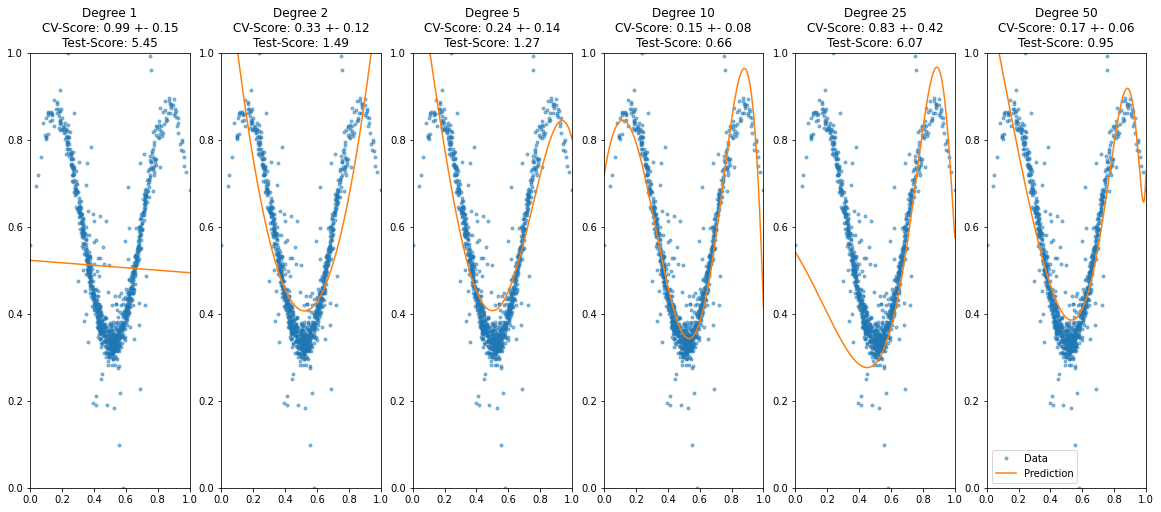

In [ ]:
%%time
results = {}
row_results = {}
q = 1
xx, yy = X_train[0], y_train[0]
for i,n in enumerate(degrees):
  
  polynomial_features = PolynomialFeatures(degree = n) # create instance of transformer
  regression = CustomRegression() # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_train, y_train, cv=10)
  
  # Make single evaluation on test set
  test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), 'Test':test_scores}
  row_results[n] = scores

  # Plot results
  line_x = np.linspace(0.0, 1.0, 1000).reshape(1000,1)
  line_y = pipeline.predict(line_x)
  
  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("Degree %i\nCV-Score: %.2f +- %.2f\nTest-Score: %.2f"%(n, results[n]['CV_mean'],results[n]['CV_std'],results[n]['Test']))
  
plt.legend()

In [ ]:
# simple way to see best runs
import pandas as pd
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std,Test
1,0.987284,0.153946,5.445527
2,0.326393,0.118145,1.487688
5,0.240975,0.139369,1.271417
10,0.154613,0.080452,0.662027
25,0.828528,0.416163,6.065037
50,0.167948,0.057825,0.949655


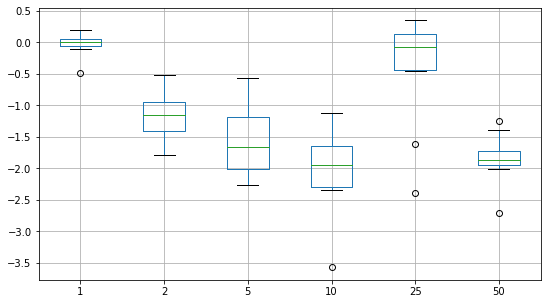

In [ ]:
# simple way to visualize model's quality and stability
# using log because of possibly huge outliers on high degrees. Remove it, if everything is  ok.
pd.DataFrame(row_results).apply(np.log).boxplot(figsize = (9,5))

# Own implementation of cross-validation 


train_cost:  1.2088293658753189
test_cost:  1.1924531164328185


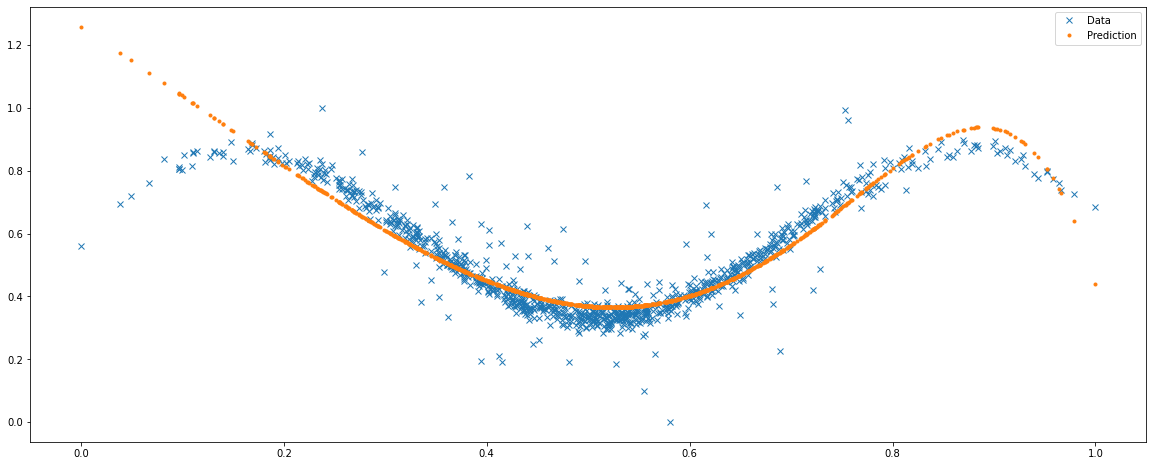

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_a, y, test_size = 0.33)
size = len(X_train)//5
for i in range(5):
    X_val = X_train[i*size:((i+1)*size-1)]
    y_val = y_train[i*size:((i+1)*size-1)]
    lp = X_train[0:(i*size-1)]    
    rp = X_train[(i+1)*size::]
    if i != 0:
        X_tr = np.concatenate((lp, rp), axis=0)
    else:
        X_tr = rp
    lp = y_train[0:(i*size-1)]    
    rp = y_train[(i+1)*size::]
    if i != 0:
        y_tr = np.concatenate((lp, rp), axis=0)
    else:
        y_tr = rp
    theta = custom_regression(X_tr, y_tr, objective_function=objective_function, loss_function=logcosh, iters = 20)
    if i == 0:
        thetas = [theta,]
    else: 
        thetas = np.append(thetas, [theta], axis=0)
train_cost = objective_function(theta=thetas.mean(axis=0), X=X_train, y=y_train)
test_cost = objective_function(theta=thetas.mean(axis=0), X=X_test, y=y_test)
print("train_cost: ",train_cost)
print("test_cost: ",test_cost)
y_pred = predict(X_a,thetas.mean(axis=0))
plt.plot(X, y, 'x', label = 'Data')
ax = plt.gca()
ax.autoscale(enable = True)
plt.plot(X, y_pred, '.', label = 'Prediction')
plt.legend()

### L2 regularization

In [ ]:
def quadratic_error(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    qe = np.sum((y_true-y_pred)**2) / len(y_true) / 2
    return qe

def L2_regulatization(theta, X,y, loss_function=quadratic_error, alpha=0):
    y_true = np.asanyarray(y)
    y_pred = predict(X, theta)
    return loss_function(y_true, y_pred)+alpha/2*np.sum((theta)**2)

def L1_regulatization(theta, X,y, loss_function=quadratic_error, alpha=0):
    y_true = np.asanyarray(y)
    y_pred = predict(X, theta)
    return loss_function(y_true, y_pred)+alpha*np.sum(abs(theta))

In [ ]:
def gradient_descent_L2(X,y,theta,alpha = 0.1,lamda = 0.05,num_iters=50000):
    m = np.size(y)
    for i in range(num_iters):
        h = np.dot(X,theta)
        theta = theta - alpha * (1/m)* (  (X.T @ (h-y)) + lamda * theta )  
    return theta

def gradient_descent_L1(X,y,theta,alpha = 0.1,lamda = 0.05,num_iters=50000):
    m = np.size(y)
    for i in range(num_iters):
        h = np.dot(X,theta)
        theta = theta - alpha * (1/m)* (  (X.T @ (h-y)) + lamda * np.sign(theta) )  
    return theta

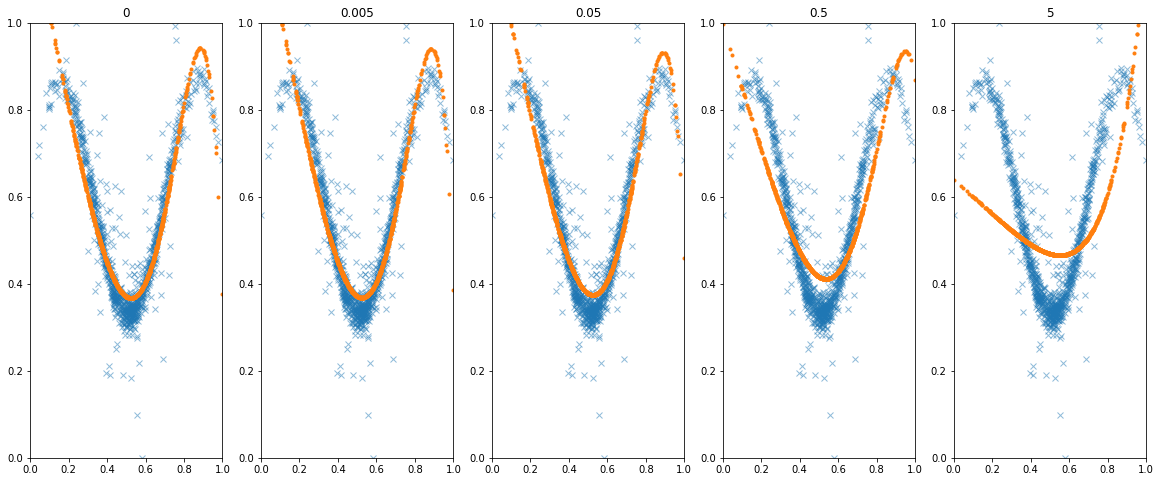

In [ ]:
lambdas = [0,0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1,5,10]
X_train, X_test, y_train, y_test = train_test_split(X_a, y, test_size = 0.33)
results = {}
for i,n in enumerate(lambdas):
  theta = gradient_descent_L2(X_train, y_train, theta = np.ones_like(X_a[0]), lamda = n)
  y_pred = predict(X_a, theta)
  results[n] = {'Test error':quadratic_error(predict(X_test, theta),y_test), 'Train error':quadratic_error(predict(X_train, theta),y_train)}
  if (i%2==0):
    ax = plt.subplot(1, 5, i//2 + 1)
    ax.plot(X, y, 'x', alpha = 0.5, label = 'Data')
    ax.autoscale(enable = False)
    ax.plot(X, y_pred, '.', label = 'Prediction')
    plt.title(n)

  #self.theta = np.ones_like(X[0])

In [ ]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,Test error,Train error
0.0,0.002462,0.002457
0.001,0.002459,0.002457
0.005,0.002450,0.002460
0.01,0.002439,0.002464
0.05,0.002388,0.002519
0.1,0.002396,0.002634
0.5,0.003480,0.004052
1.0,0.004919,0.005545
5.0,0.009024,0.009569
10.0,0.010645,0.011171


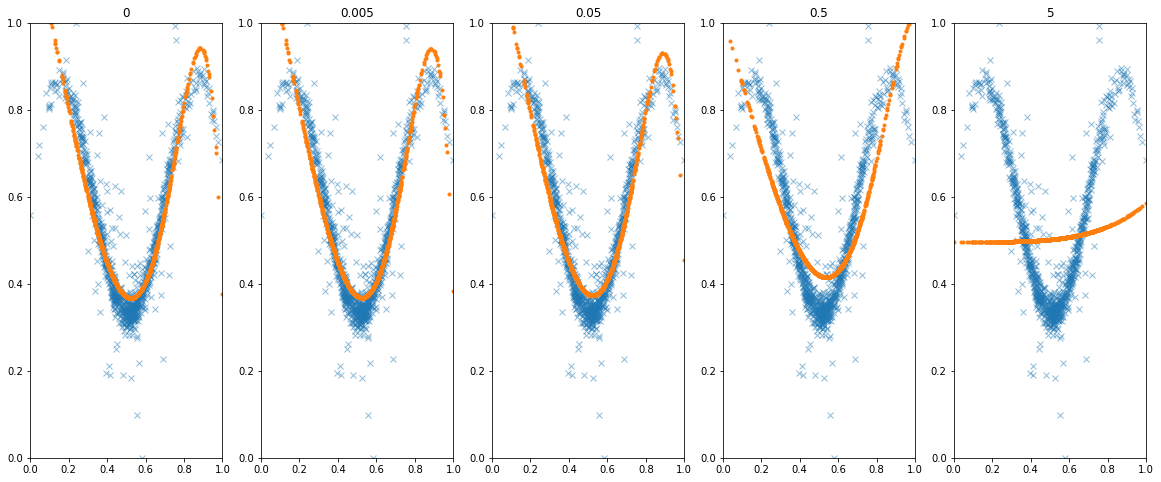

In [ ]:
results = {}
for i,n in enumerate(lambdas):
  theta = gradient_descent_L1(X_train, y_train, theta = np.ones_like(X_a[0]), lamda = n)
  y_pred = predict(X_a, theta)
  results[n] = {'Test error':quadratic_error(predict(X_test, theta),y_test), 'Train error':quadratic_error(predict(X_train, theta),y_train)}
  if (i%2==0):
    ax = plt.subplot(1, 5, i//2 + 1)
    ax.plot(X, y, 'x', alpha = 0.5, label = 'Data')
    ax.autoscale(enable = False)
    ax.plot(X, y_pred, '.', label = 'Prediction')
    plt.title(n)

  #self.theta = np.ones_like(X[0])

In [ ]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,Test error,Train error
0.0,0.002462,0.002457
0.001,0.002461,0.002458
0.005,0.002459,0.002465
0.01,0.002457,0.002473
0.05,0.002459,0.002551
0.1,0.002464,0.002648
0.5,0.003898,0.004438
1.0,0.006350,0.006908
5.0,0.014765,0.014634
10.0,0.015595,0.015305


As we can see, L2 and L1 normalization increase Train error, but test error decrices

With L2 we receive lowest test error, and Lambda parameter should be about 0.05 for this data 